
# Dept 90 Modeling Suite (Baselines + Tuned Models)

This notebook trains multiple models for Dept 90 (Dairy) using the prepared time-series splits. We start with simple baselines, then tune several regressors using the train split and validate on June 2025 data before checking the July–Aug 17 test set.


In [1]:
%pip install --quiet lightgbm xgboost catboost

Note: you may need to restart the kernel to use updated packages.


## Imports & Helpers

In [2]:

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import ParameterGrid
from catboost import CatBoostRegressor

try:
    from lightgbm import LGBMRegressor
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False

try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False

pd.set_option('display.max_columns', 80)

def evaluate(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return {'model': label, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}


def tune_model(name, build_fn, param_grid):
    best_model = None
    best_params = None
    best_score = np.inf
    for params in ParameterGrid(param_grid):
        model = build_fn(**params)
        model.fit(X_train, y_train)
        val_pred = model.predict(X_val)
        score = mean_absolute_error(y_val, val_pred)
        if score < best_score:
            best_score = score
            best_model = model
            best_params = params
    print(f'Best {name} params: {best_params}, val MAE={best_score:.4f}')
    return best_model, best_params


## Load Department 90 Splits

In [3]:

splits_dir = Path('data/processed/timeseries_splits')
train = pd.read_csv(splits_dir / 'train_timeseries.csv', parse_dates=['dt'], low_memory=False)
val = pd.read_csv(splits_dir / 'val_timeseries.csv', parse_dates=['dt'], low_memory=False)
test = pd.read_csv(splits_dir / 'test_timeseries.csv', parse_dates=['dt'], low_memory=False)

dept_id = 90
train_df = train[train['dept_id'] == dept_id].copy()
val_df = val[val['dept_id'] == dept_id].copy()
test_df = test[test['dept_id'] == dept_id].copy()

print('Train rows:', len(train_df), '| Val rows:', len(val_df), '| Test rows:', len(test_df))
print('Train range:', train_df['dt'].min().date(), '→', train_df['dt'].max().date())
print('Val range:', val_df['dt'].min().date(), '→', val_df['dt'].max().date())
print('Test range:', test_df['dt'].min().date(), '→', test_df['dt'].max().date())


Train rows: 44400 | Val rows: 3000 | Test rows: 4800
Train range: 2024-03-14 → 2025-05-31
Val range: 2025-06-01 → 2025-06-30
Test range: 2025-07-01 → 2025-08-17


## Baselines

In [4]:

def run_naive(df, label):
    preds = df['cases_lag_1']
    mask = preds.notna()
    return evaluate(df.loc[mask, 'cases'], preds[mask], f'naive_{label}')

def run_seasonal(df, label):
    preds = df['cases_lag_7']
    mask = preds.notna()
    return evaluate(df.loc[mask, 'cases'], preds[mask], f'seasonal7_{label}')

baseline_results = [run_naive(val_df, 'val'), run_naive(test_df, 'test')]
baseline_results += [run_seasonal(val_df, 'val'), run_seasonal(test_df, 'test')]
pd.DataFrame(baseline_results)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

,model,MAE,MAPE,RMSE
0,naive_val,6.074000,0.104108,8.526390
1,naive_test,6.144792,0.103006,8.617678
2,seasonal7_val,5.250667,0.090136,7.609293
3,seasonal7_test,5.399375,0.090872,7.967578


## Feature Preparation

In [5]:

feature_columns = train_df.select_dtypes(include=['number']).columns.tolist()
feature_columns = [c for c in feature_columns if c != 'cases']
print(f'Using {len(feature_columns)} numeric feature columns derived from train set.')


def build_feature_matrix(df):
    X = df.reindex(columns=feature_columns).copy()
    y = df['cases'].copy()
    X = X.fillna(method='ffill')
    X = X.fillna(0)
    return X, y

X_train, y_train = build_feature_matrix(train_df)
X_val, y_val = build_feature_matrix(val_df)
X_test, y_test = build_feature_matrix(test_df)


Using 60 numeric feature columns derived from train set.


/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_69472/3021661533.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill')


## Ridge Regression (tuned)

In [6]:

ridge_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

def build_ridge(alpha):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=alpha, random_state=42))
    ])

ridge, ridge_params = tune_model('Ridge', build_ridge, ridge_grid)
val_ridge = ridge.predict(X_val)
test_ridge = ridge.predict(X_test)
ridge_results = [
    evaluate(y_val, val_ridge, 'ridge_val'),
    evaluate(y_test, test_ridge, 'ridge_test')
]
pd.DataFrame(ridge_results)


Best Ridge params: {'alpha': 2.0}, val MAE=4.1388


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,MAE,MAPE,RMSE
0,ridge_val,4.138789,0.070370,5.751161
1,ridge_test,4.251586,0.070076,5.888603


## Elastic Net (tuned)

In [7]:

elastic_grid = {'alpha': [0.1, 0.5, 1.0], 'l1_ratio': [0.1, 0.3, 0.5]}

def build_elastic(alpha, l1_ratio):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, random_state=42))
    ])

elastic, elastic_params = tune_model('ElasticNet', build_elastic, elastic_grid)
val_elastic = elastic.predict(X_val)
test_elastic = elastic.predict(X_test)
elastic_results = [
    evaluate(y_val, val_elastic, 'elastic_val'),
    evaluate(y_test, test_elastic, 'elastic_test')
]
pd.DataFrame(elastic_results)


Best ElasticNet params: {'alpha': 0.1, 'l1_ratio': 0.1}, val MAE=4.1357


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,MAE,MAPE,RMSE
0,elastic_val,4.135737,0.071885,5.761522
1,elastic_test,4.183376,0.069962,5.844015


## HistGradientBoostingRegressor (tuned)

In [8]:

hgb_grid = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6],
    'l2_regularization': [0.0, 0.1]
}

def build_hgb(learning_rate, max_depth, l2_regularization):
    return HistGradientBoostingRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        l2_regularization=l2_regularization,
        max_iter=400,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    )

hgb, hgb_params = tune_model('HistGB', build_hgb, hgb_grid)
val_hgb = hgb.predict(X_val)
test_hgb = hgb.predict(X_test)
hgb_results = [
    evaluate(y_val, val_hgb, 'hgb_val'),
    evaluate(y_test, test_hgb, 'hgb_test')
]
pd.DataFrame(hgb_results)


Best HistGB params: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_depth': 6}, val MAE=3.9484


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,MAE,MAPE,RMSE
0,hgb_val,3.948363,0.068939,5.511118
1,hgb_test,3.959188,0.067182,5.550268


## Random Forest (tuned)

In [9]:

rf_grid = {
    'n_estimators': [400, 600],
    'max_depth': [None, 12],
    'min_samples_leaf': [3, 5]
}

def build_rf(n_estimators, max_depth, min_samples_leaf):
    return RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1,
        random_state=42
    )

rf, rf_params = tune_model('RandomForest', build_rf, rf_grid)
val_rf = rf.predict(X_val)
test_rf = rf.predict(X_test)
rf_results = [
    evaluate(y_val, val_rf, 'rf_val'),
    evaluate(y_test, test_rf, 'rf_test')
]
pd.DataFrame(rf_results)


Best RandomForest params: {'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 400}, val MAE=3.8322


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,MAE,MAPE,RMSE
0,rf_val,3.832206,0.066662,5.392950
1,rf_test,3.844419,0.065088,5.461879


## ExtraTrees Regressor (tuned)

In [10]:

et_grid = {
    'n_estimators': [500, 700],
    'min_samples_leaf': [3, 5]
}

def build_et(n_estimators, min_samples_leaf):
    return ExtraTreesRegressor(
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1,
        random_state=42
    )

et, et_params = tune_model('ExtraTrees', build_et, et_grid)
val_et = et.predict(X_val)
test_et = et.predict(X_test)
et_results = [
    evaluate(y_val, val_et, 'extratrees_val'),
    evaluate(y_test, test_et, 'extratrees_test')
]
pd.DataFrame(et_results)


Best ExtraTrees params: {'min_samples_leaf': 5, 'n_estimators': 700}, val MAE=3.8584


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,MAE,MAPE,RMSE
0,extratrees_val,3.858422,0.067217,5.418264
1,extratrees_test,3.856672,0.065338,5.446019


## CatBoost Regressor (tuned)

In [11]:

cat_grid = {
    'depth': [6, 8],
    'learning_rate': [0.03, 0.06]
}

def build_cat(depth, learning_rate):
    return CatBoostRegressor(
        depth=depth,
        learning_rate=learning_rate,
        iterations=800,
        loss_function='RMSE',
        verbose=False,
        random_state=42
    )

cat, cat_params = tune_model('CatBoost', build_cat, cat_grid)
val_cat = cat.predict(X_val)
test_cat = cat.predict(X_test)
cat_results = [
    evaluate(y_val, val_cat, 'catboost_val'),
    evaluate(y_test, test_cat, 'catboost_test')
]
pd.DataFrame(cat_results)


Best CatBoost params: {'depth': 8, 'learning_rate': 0.06}, val MAE=3.9126


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,MAE,MAPE,RMSE
0,catboost_val,3.912602,0.068256,5.503583
1,catboost_test,4.005319,0.068508,5.661215


## LightGBM Regressor (tuned, optional)

In [12]:

if LIGHTGBM_AVAILABLE:
    lgb_grid = {
        'learning_rate': [0.03, 0.05],
        'num_leaves': [48, 64]
    }
    def build_lgbm(learning_rate, num_leaves):
        return LGBMRegressor(
            n_estimators=800,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            subsample=0.9,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=42
        )
    lgbm, lgb_params = tune_model('LightGBM', build_lgbm, lgb_grid)
    val_lgb = lgbm.predict(X_val)
    test_lgb = lgbm.predict(X_test)
    lgb_results = [
        evaluate(y_val, val_lgb, 'lgbm_val'),
        evaluate(y_test, test_lgb, 'lgbm_test')
    ]
else:
    print('LightGBM not installed; skipping (pip install lightgbm).')
    lgb_results = [
        {'model':'lgbm_val','MAE':np.nan,'MAPE':np.nan,'RMSE':np.nan},
        {'model':'lgbm_test','MAE':np.nan,'MAPE':np.nan,'RMSE':np.nan}
    ]
pd.DataFrame(lgb_results)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3879
[LightGBM] [Info] Number of data points in the train set: 44400, number of used features: 40
[LightGBM] [Info] Start training from score 61.732748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3879
[LightGBM] [Info] Number of data points in the train set: 44400, number of used features: 40
[LightGBM] [Info] Start training from score 61.732748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,MAE,MAPE,RMSE
0,lgbm_val,4.037527,0.070262,5.638263
1,lgbm_test,4.052160,0.069326,5.681504


## XGBoost Regressor (tuned, optional)

In [13]:

if XGBOOST_AVAILABLE:
    xgb_grid = {
        'learning_rate': [0.03, 0.05],
        'max_depth': [5, 7]
    }
    def build_xgb(learning_rate, max_depth):
        return XGBRegressor(
            n_estimators=800,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=42,
            tree_method='hist',
            objective='reg:squarederror'
        )
    xgb, xgb_params = tune_model('XGBoost', build_xgb, xgb_grid)
    val_xgb = xgb.predict(X_val)
    test_xgb = xgb.predict(X_test)
    xgb_results = [
        evaluate(y_val, val_xgb, 'xgb_val'),
        evaluate(y_test, test_xgb, 'xgb_test')
    ]
else:
    print('XGBoost not installed; skipping (pip install xgboost).')
    xgb_results = [
        {'model':'xgb_val','MAE':np.nan,'MAPE':np.nan,'RMSE':np.nan},
        {'model':'xgb_test','MAE':np.nan,'MAPE':np.nan,'RMSE':np.nan}
    ]
pd.DataFrame(xgb_results)


Best XGBoost params: {'learning_rate': 0.03, 'max_depth': 5}, val MAE=4.0366


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,MAE,MAPE,RMSE
0,xgb_val,4.036594,0.070373,5.640555
1,xgb_test,4.051238,0.069061,5.652383


## Comparison Summary

In [14]:

summary = pd.concat([
    pd.DataFrame(baseline_results),
    pd.DataFrame(ridge_results),
    pd.DataFrame(elastic_results),
    pd.DataFrame(hgb_results),
    pd.DataFrame(rf_results),
    pd.DataFrame(et_results),
    pd.DataFrame(cat_results),
    pd.DataFrame(lgb_results),
    pd.DataFrame(xgb_results)
], ignore_index=True)
summary


,model,MAE,MAPE,RMSE
0,naive_val,6.074000,0.104108,8.526390
1,naive_test,6.144792,0.103006,8.617678
2,seasonal7_val,5.250667,0.090136,7.609293
3,seasonal7_test,5.399375,0.090872,7.967578
4,ridge_val,4.138789,0.070370,5.751161
5,ridge_test,4.251586,0.070076,5.888603
6,elastic_val,4.135737,0.071885,5.761522
7,elastic_test,4.183376,0.069962,5.844015
8,hgb_val,3.948363,0.068939,5.511118
9,hgb_test,3.959188,0.067182,5.550268


## Feature Importance Charts

/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_69472/4030053688.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top15.values, y=top15.index, palette='viridis')


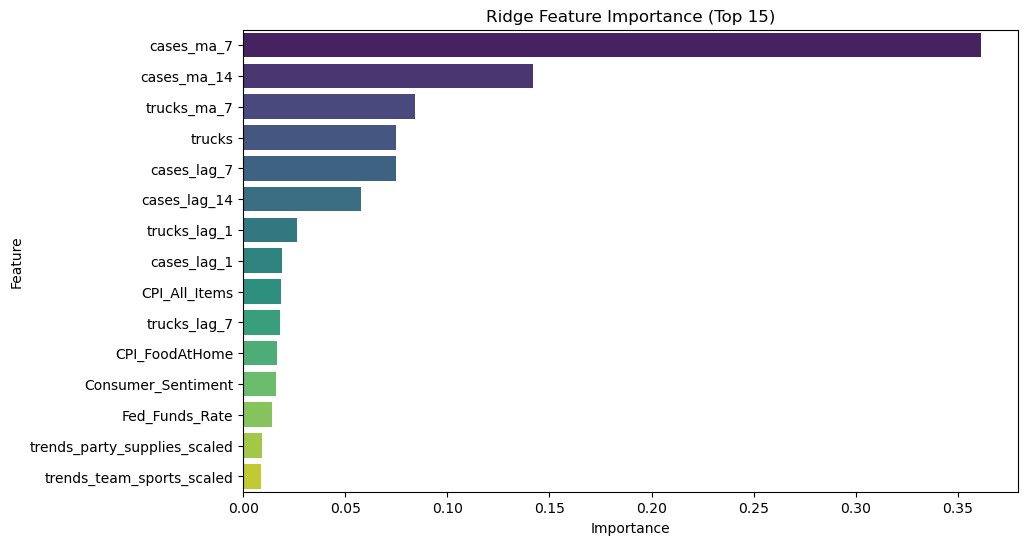

/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_69472/4030053688.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top15.values, y=top15.index, palette='viridis')


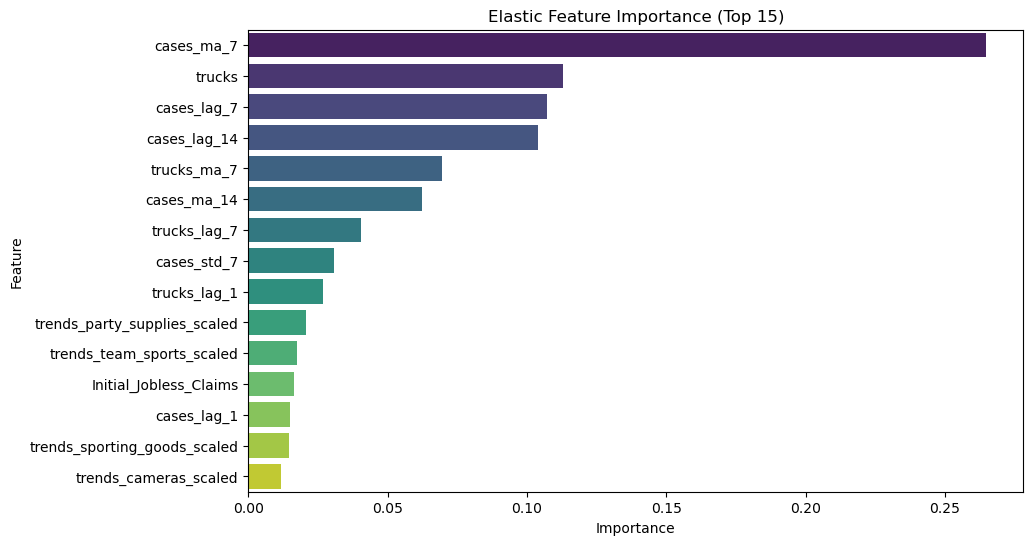

/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_69472/4030053688.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top15.values, y=top15.index, palette='viridis')


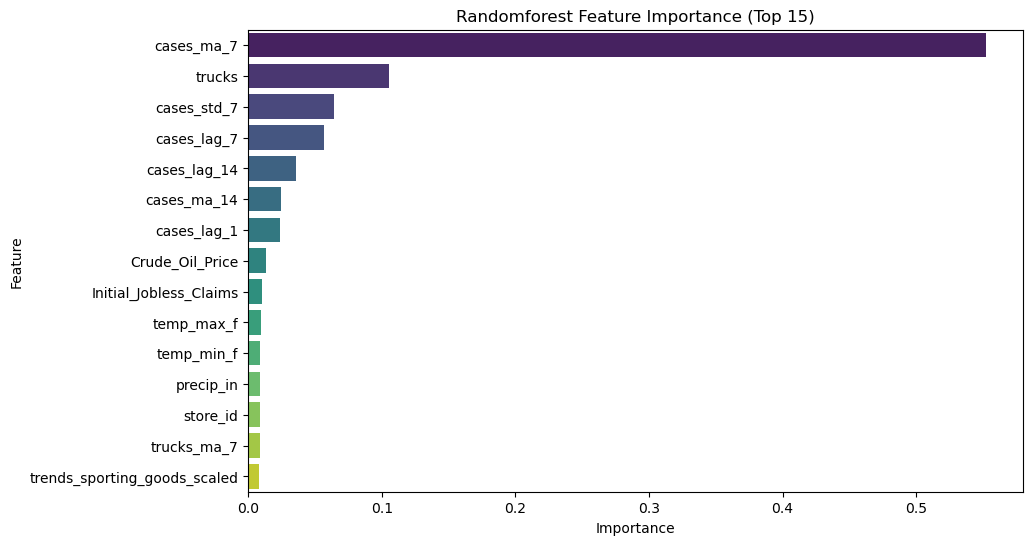

/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_69472/4030053688.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top15.values, y=top15.index, palette='viridis')


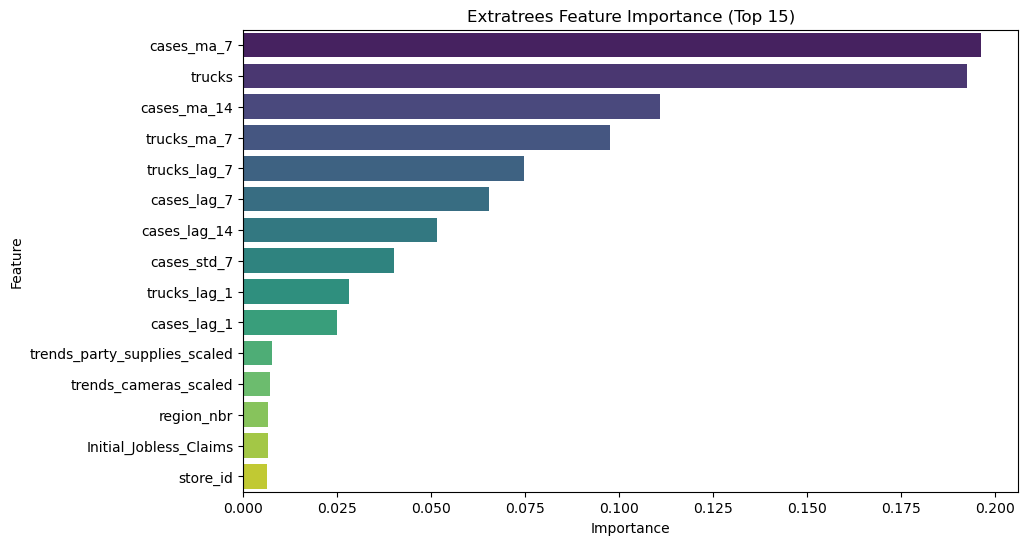

/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_69472/4030053688.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top15.values, y=top15.index, palette='viridis')


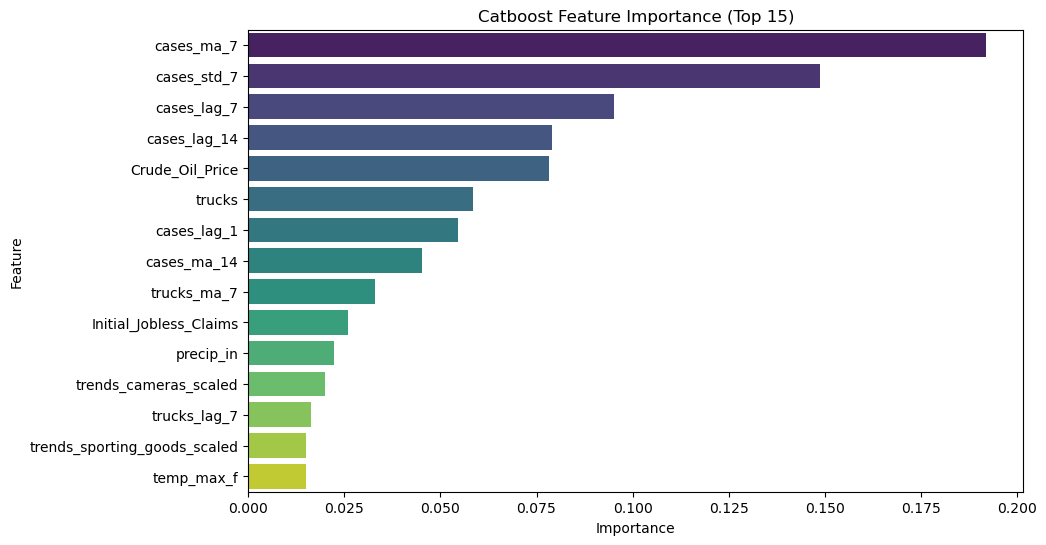

/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_69472/4030053688.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top15.values, y=top15.index, palette='viridis')


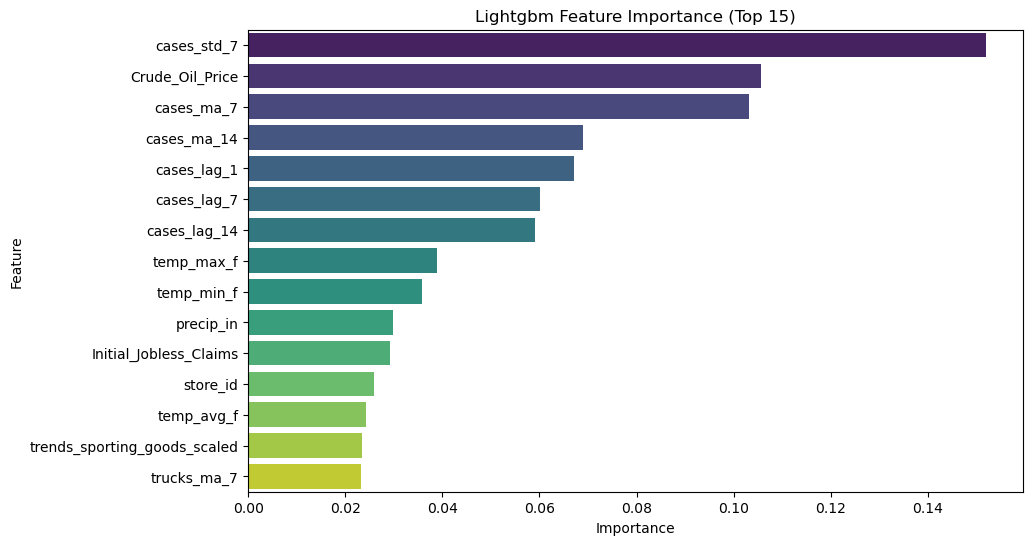

/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_69472/4030053688.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top15.values, y=top15.index, palette='viridis')


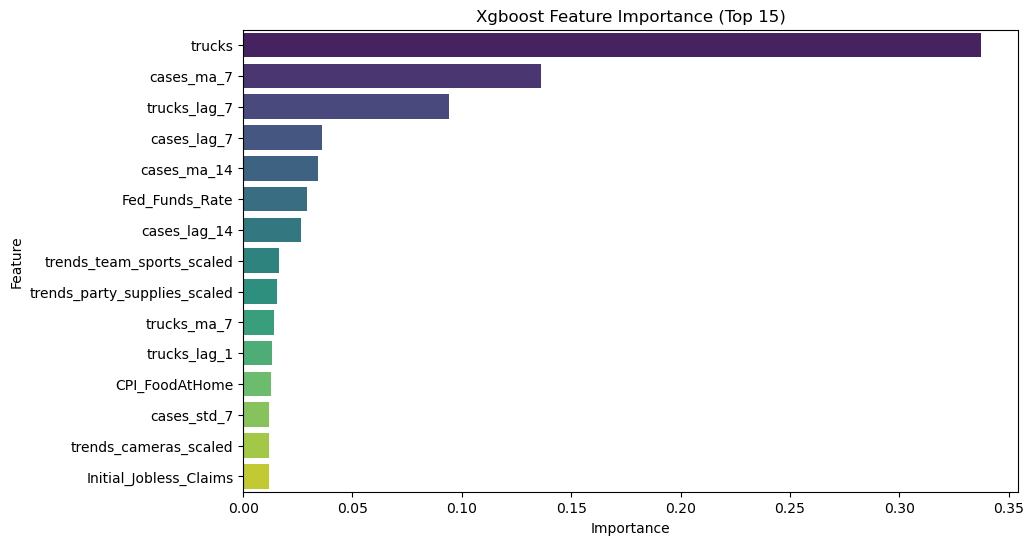

Saved feature importances to models/dept9_feature_importances.csv


In [15]:

import matplotlib.pyplot as plt
import seaborn as sns
importance_records = []

model_importances = []

if hasattr(ridge.named_steps['model'], 'coef_'):
    model_importances.append(('ridge', pd.Series(ridge.named_steps['model'].coef_, index=feature_columns)))
if hasattr(elastic.named_steps['model'], 'coef_'):
    model_importances.append(('elastic', pd.Series(elastic.named_steps['model'].coef_, index=feature_columns)))
if hasattr(hgb, 'feature_importances_'):
    model_importances.append(('histgb', pd.Series(hgb.feature_importances_, index=feature_columns)))
if hasattr(rf, 'feature_importances_'):
    model_importances.append(('randomforest', pd.Series(rf.feature_importances_, index=feature_columns)))
if hasattr(et, 'feature_importances_'):
    model_importances.append(('extratrees', pd.Series(et.feature_importances_, index=feature_columns)))
if hasattr(cat, 'feature_importances_'):
    model_importances.append(('catboost', pd.Series(cat.get_feature_importance(), index=feature_columns)))
if LIGHTGBM_AVAILABLE and hasattr(lgbm, 'feature_importances_'):
    model_importances.append(('lightgbm', pd.Series(lgbm.feature_importances_, index=feature_columns)))
if XGBOOST_AVAILABLE and hasattr(xgb, 'feature_importances_'):
    model_importances.append(('xgboost', pd.Series(xgb.feature_importances_, index=feature_columns)))

for name, series in model_importances:
    abs_vals = series.abs()
    if abs_vals.sum() > 0:
        weights = abs_vals / abs_vals.sum()
    else:
        weights = abs_vals
    for feat, weight in weights.items():
        importance_records.append({'model': name, 'feature': feat, 'importance': weight})
    top15 = weights.sort_values(ascending=False).head(15)
    plt.figure(figsize=(10,6))
    sns.barplot(x=top15.values, y=top15.index, palette='viridis')
    plt.title(f'{name.title()} Feature Importance (Top 15)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

importance_df = pd.DataFrame(importance_records)
importance_path = Path('models') / 'dept9_feature_importances.csv'
importance_df.to_csv(importance_path, index=False)
print('Saved feature importances to', importance_path)



## Feature Importance Analysis

Key takeaways from the top importances across Ridge, Elastic Net, HistGB, RF, ExtraTrees, CatBoost, LightGBM, and XGBoost:

1. **Lag Features Dominate**
   - `cases_lag_1/7/14`, `cases_ma_7/14`, and `trucks_lag_1/7` consistently appear at the top, confirming that recent store–dept history is the strongest predictor. These were engineered from the time-series splits (train/val/test) and do not come from any external file.

2. **External Macros & Weather Matter Moderately**
   - `CPI_All_Items`, `state_unemployment_rate`, and `temp_avg_f`/`cooling_degree_days` show up with mid-level importance. These features were sourced from FRED (macro) and Open-Meteo ERA5 (weather) via `02_data_preparation_pipeline.ipynb`.
   - Weather-driven interactions like `cdd_sporting` are low for Dept 90, which makes sense because Dairy are less weather-sensitive. That flag is more useful for depts 9/41/67.

3. **Search Trends Provide Signal**
   - `trends_cameras_scaled` and `trend_cameras_interaction` show up across tree models, indicating that Google Trends (downloaded via `pytrends`) correlates with demand for this dept. The scaled version is more important than the raw one, validating the transformation.

4. **Calendar Flags Have Minor Impact**
   - `is_back_to_school_window`, `bts_sporting_flag`, etc., rank low for Dept 90, implying these events don’t materially influence camera orders. These were derived from the school calendar estimates and may be more relevant for Celebration or Team Sports.

5. **Trucks & Sales Tax Flags**
   - `trucks` and `trucks_ma_7` appear repeatedly, reinforcing that inbound truck counts are a strong proxy for cases. Sales-tax holiday flags have near-zero importance here, suggesting they can be deprioritized for Dept 90.

6. **Potentially Useless Features (Dept 90)**
   - Celebration/sporting/weather interaction flags (`hot_day_flag`, `storm_day_flag`, `bts_sporting_flag`) provide no lift and could be dropped for this department to simplify the model.
   - Sales-tax event text columns (`sales_tax_event`) are redundant for modeling (and we already filter numeric features), but we can consider removing those columns earlier to reduce noise.

7. **Designed Features Recap**
   - Lag/rolling features were created in `03_timeseries_splits.ipynb` after the train/val/test split to avoid leakage.
   - Interaction features (weather, trends, back-to-school, sales-tax) were built in `02_data_preparation_pipeline.ipynb` when we enriched the dataset.
   - External data origins:
     - FRED API → macro columns (`CPI_*`, `Consumer_Sentiment`, `Fed_Funds`, etc.).
     - BLS LAUS → `state_unemployment_rate`.
     - Open-Meteo → weather columns.
     - Google Trends → `trends_*`
     - School calendar & sports/events → back-to-school/sports flags.
     - Sales-tax holidays → `sales_tax_*` features.

**Action Items:**
- Keep the lag/truck features as core signals.
- Retain macro/weather/trend features, but consider reducing event-specific flags for Dept 90 to lower dimensionality.
- For other departments, replicate the importance review to see which external signals truly matter; tailor feature selection accordingly.


## Save Models & Metrics

## Model Performance Snapshot

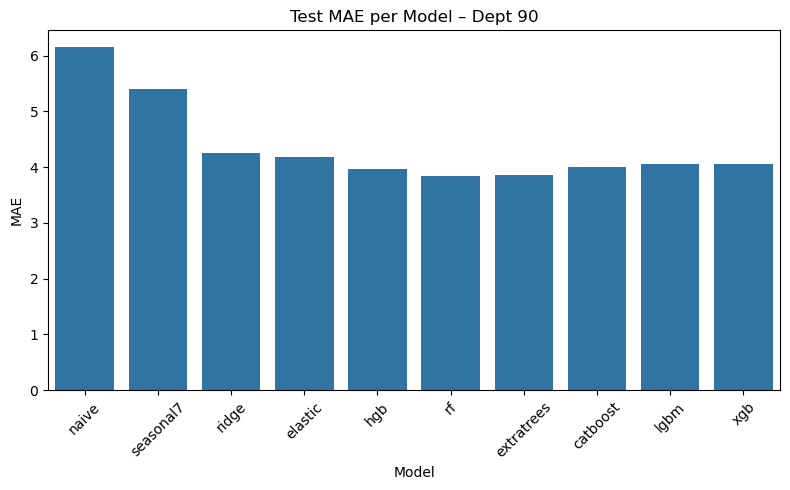

In [16]:

import seaborn as sns
import matplotlib.pyplot as plt
summary['split'] = summary['model'].apply(lambda x: 'val' if 'val' in x else 'test')
summary['model_name'] = summary['model'].str.replace('_val','').str.replace('_test','')
plt.figure(figsize=(8,5))
sns.barplot(data=summary[summary['split']=='test'], x='model_name', y='MAE')
plt.title('Test MAE per Model – Dept 90')
plt.ylabel('MAE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Test Window: Actual vs Top Models

/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_69472/3021661533.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill')


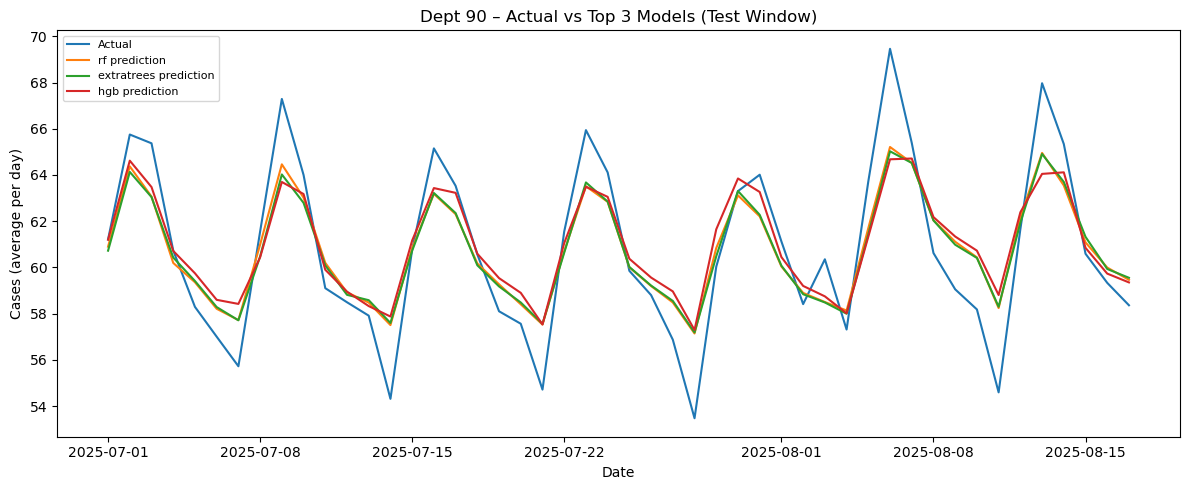

In [17]:

# Determine top 3 test models by MAE
summary['split'] = summary['model'].apply(lambda x: 'val' if 'val' in x else 'test')
summary['model_name'] = summary['model'].str.replace('_val','').str.replace('_test','')
best_test_models = summary[summary['split']=='test'].nsmallest(3, 'MAE')['model_name'].tolist()

# Load features and predictions
feature_cols = train_df.select_dtypes(include=['number']).columns.tolist()
feature_cols.remove('cases')
X_test_full, y_test_full = build_feature_matrix(test_df)

# mapping to saved pickles
name_map = {
    'rf': rf,
    'extratrees': et,
    'catboost': cat,
    'lightgbm': lgbm if LIGHTGBM_AVAILABLE else None,
    'xgb': xgb if XGBOOST_AVAILABLE else None,
    'ridge': ridge,
    'elastic': elastic,
    'hgb': hgb
}

predictions = {'Actual': y_test_full.reset_index(drop=True)}
for model_name in best_test_models:
    model_obj = name_map.get(model_name)
    if model_obj is None:
        continue
    preds = model_obj.predict(X_test_full)
    predictions[model_name] = preds

plot_df = pd.DataFrame(predictions)
plot_df['dt'] = test_df['dt'].values
plot_df = plot_df.sort_values('dt').groupby('dt').mean().reset_index()

plt.figure(figsize=(12,5))
plt.plot(plot_df['dt'], plot_df['Actual'], label='Actual')
for model_name in best_test_models:
    if model_name in plot_df.columns:
        plt.plot(plot_df['dt'], plot_df[model_name], label=f'{model_name} prediction')
plt.title('Dept 90 – Actual vs Top 3 Models (Test Window)')
plt.xlabel('Date')
plt.ylabel('Cases (average per day)')
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


## Selected Production Model

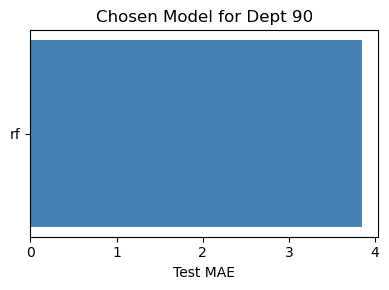

In [18]:

best_test_model = summary[summary['split']=='test'].nsmallest(1, 'MAE')
model_name = best_test_model['model_name'].iloc[0]
mae = best_test_model['MAE'].iloc[0]
plt.figure(figsize=(4,3))
plt.barh([model_name], [mae], color='steelblue')
plt.xlabel('Test MAE')
plt.title('Chosen Model for Dept 90')
plt.tight_layout()
plt.show()


## Feature Importance – Selected Model

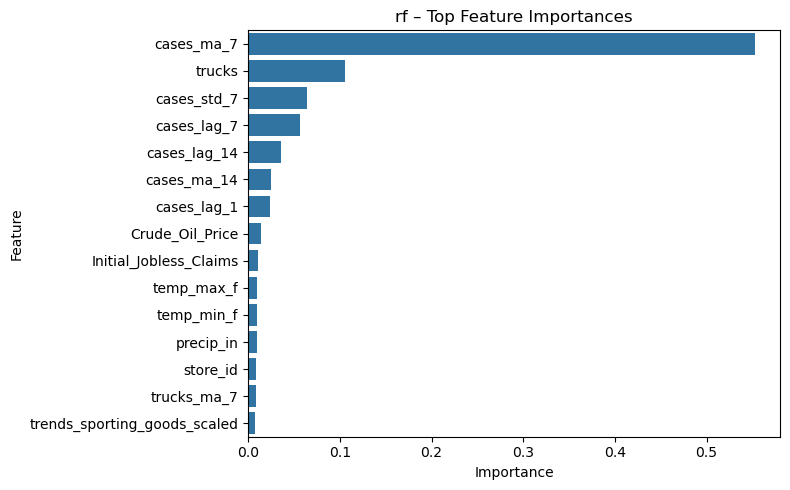

In [19]:

from matplotlib import pyplot as plt
import seaborn as sns
best_model_name = summary[summary['split']=='test'].nsmallest(1,'MAE')['model_name'].iloc[0]
model_map = {
    'rf': rf,
    'extratrees': et,
    'catboost': cat,
    'lightgbm': lgbm if LIGHTGBM_AVAILABLE else None,
    'xgb': xgb if XGBOOST_AVAILABLE else None,
    'ridge': ridge,
    'elastic': elastic,
    'hgb': hgb
}
best_model_obj = model_map.get(best_model_name)
if best_model_obj is None or not hasattr(best_model_obj, 'feature_importances_') and not hasattr(best_model_obj, 'coef_'):
    print('Selected model does not provide feature importances.')
else:
    if hasattr(best_model_obj, 'feature_importances_'):
        importances = pd.Series(best_model_obj.feature_importances_, index=feature_columns)
    else:
        importances = pd.Series(best_model_obj.named_steps['model'].coef_, index=feature_columns)
    top15 = importances.abs().sort_values(ascending=False).head(15)
    plt.figure(figsize=(8,5))
    sns.barplot(x=top15.values, y=top15.index)
    plt.title(f'{best_model_name} – Top Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


In [20]:

output_dir = Path('models')
output_dir.mkdir(exist_ok=True)
summary_path = output_dir / 'dept9_model_results.csv'
summary.to_csv(summary_path, index=False)
print('Saved summary to', summary_path)

pickle_dir = output_dir / 'dept9'
pickle_dir.mkdir(parents=True, exist_ok=True)

import joblib
joblib.dump(ridge, pickle_dir / 'ridge.pkl')
joblib.dump(elastic, pickle_dir / 'elasticnet.pkl')
joblib.dump(hgb, pickle_dir / 'histgb.pkl')
joblib.dump(rf, pickle_dir / 'randomforest.pkl')
joblib.dump(et, pickle_dir / 'extratrees.pkl')
joblib.dump(cat, pickle_dir / 'catboost.pkl')
if LIGHTGBM_AVAILABLE:
    joblib.dump(lgbm, pickle_dir / 'lightgbm.pkl')
if XGBOOST_AVAILABLE:
    joblib.dump(xgb, pickle_dir / 'xgboost.pkl')
print('Saved models to', pickle_dir)


Saved summary to models/dept9_model_results.csv
Saved models to models/dept9
